<a href="https://colab.research.google.com/github/Kate-Strydom/cse450/blob/main/house_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import 

In [46]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [27]:
#!pip install GeoPandas

In [59]:
print("Loading Shapefile...")
shapefile = gpd.read_file("/content/gdrive/My Drive/shapefile/tl_2016_53_cousub.shp")


Loading Shapefile...


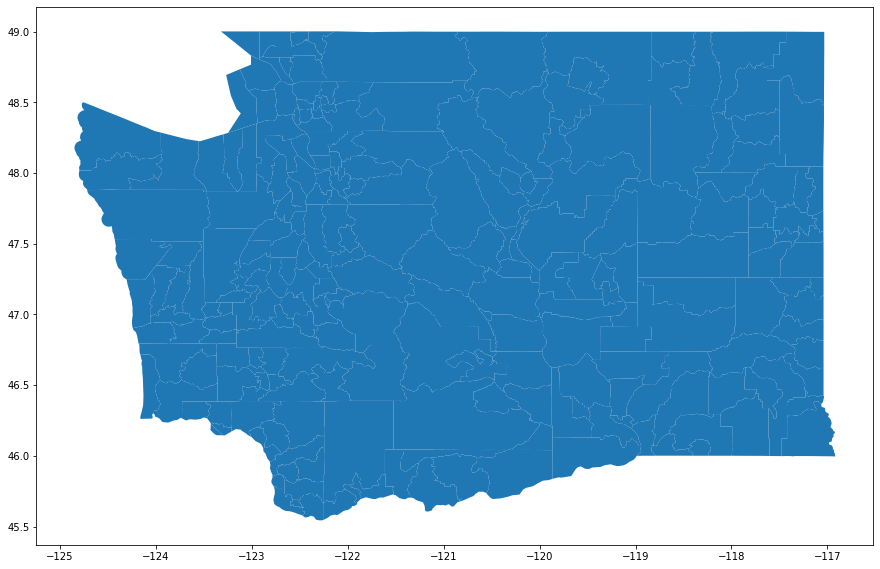

In [62]:
fig, ax = plt.subplots(figsize = (15,15))
shapefile.plot(ax=ax)

In [63]:
# show shapefile
shapefile.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,53,003,90096,01939443,5300390096,Asotin,Asotin CCD,22,Z5,G4040,None,None,None,S,1340244511,8191372,+46.1474746,-117.1964025,"POLYGON ((-117.47997 46.01631, -117.47991 46.0..."
1,53,003,90592,01939474,5300390592,Clarkston,Clarkston CCD,22,Z5,G4040,None,None,None,S,307199433,3084334,+46.3442652,-117.3012796,"POLYGON ((-117.42077 46.33866, -117.42073 46.3..."
2,53,075,90656,01939478,5307590656,Colfax-Palouse,Colfax-Palouse CCD,22,Z5,G4040,None,None,None,S,608990251,10534,+46.8961192,-117.2915620,"POLYGON ((-117.58929 46.86652, -117.58926 46.8..."
3,53,075,91552,01939535,5307591552,LaCrosse,LaCrosse CCD,22,Z5,G4040,None,None,None,S,1318314850,24179160,+46.7282243,-117.8212524,"POLYGON ((-118.24934 46.73384, -118.24912 46.7..."
4,53,075,92832,01939615,5307592832,Rock Lake,Rock Lake CCD,22,Z5,G4040,None,None,None,S,1577017631,11603165,+47.0541435,-117.7254566,"POLYGON ((-118.00506 46.84360, -118.00498 46.8..."


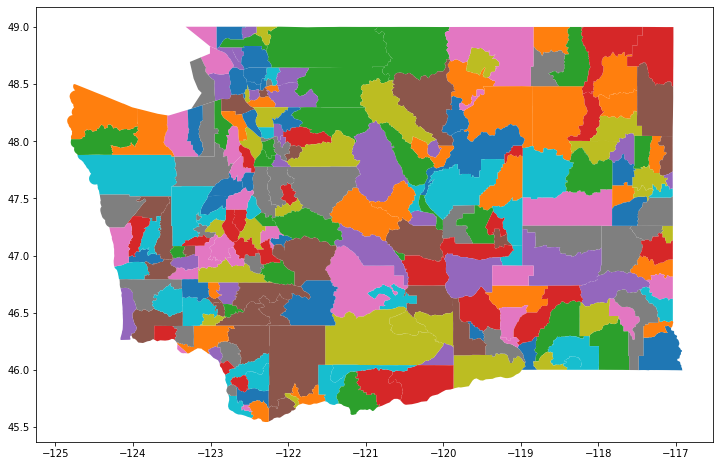

In [66]:
shapefile.plot(column='NAME', figsize=(16,8))

In [73]:
#from sys import platform

import pandas as pd
import numpy as np

import geopandas as gpd
import descartes
import shapely.geometry

%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor

#from sklearn import preprocessing, model_selection, ensemble, metrics, pipeline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import pickle


In [74]:
# disable scientific notation
pd.set_option('display.float_format', lambda x: '%.9f' % x)
# reset
#pd.reset_option('display.float_format', silent=True)

## Data Preprocessing 

In [75]:
housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')
# data is from 2010 -2014
# inflation between 2014 and 2015 hardly changed.
zipcode = pd.read_csv('https://raw.githubusercontent.com/Kate-Strydom/cse450/main/notebooks/zipcode_washington.csv')

# merge data on zipcodes
data_merged = housing.merge(zipcode, left_on='zipcode', right_on='zipcode')
#print(housing.info())
#print(zipcode.info())
#print(housing.head())
#print(zipcode.head())
#print(data.head())
#print(data.describe())
#print(data.info())
# number of observations 
len(data_merged.index)

20000

In [76]:
# rename lat : latitude and long: longitude
#data_merged.rename(columns={"lat": "latitude"}, inplace=True)

In [77]:
crs = {'init': 'epsg:4326' }


In [78]:
data_merged.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,population,median_household_income
0,1565930130,20141104T000000,4,3.250000000,3760,4675,2.000000000,0,0,3,...,2007,0,98038,47.386200000,-122.048000000,3280,4033,429900.000000000,34076,93573
1,6699940320,20150413T000000,4,2.500000000,2600,5188,2.000000000,0,0,3,...,2005,0,98038,47.345100000,-122.040000000,2610,5188,359900.000000000,34076,93573
2,5416500260,20140908T000000,3,2.500000000,1890,3629,2.000000000,0,0,3,...,2005,0,98038,47.361300000,-122.041000000,1980,4000,285000.000000000,34076,93573
3,1442700430,20140808T000000,5,2.500000000,3180,23809,1.000000000,0,0,3,...,1978,0,98038,47.372700000,-122.054000000,2500,15778,499950.000000000,34076,93573
4,522069119,20150512T000000,3,2.500000000,2720,62310,1.000000000,0,0,3,...,1985,0,98038,47.416800000,-122.074000000,2770,204296,550000.000000000,34076,93573


## How to work with latitude and longitude 


<https://towardsdatascience.com/things-to-do-with-latitude-longitude-data-using-geopy-python-1d356ed1ae30>



In [79]:
# holdout sample to be submitted
holdout = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test.csv')

In [80]:
holdout.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,4,2.250000000,2070,8893,2.000000000,0,0,4,8,2070,0,1986,0,98058,47.438800000,-122.162000000,2390,7700
1,7974200820,20140821T000000,5,3.000000000,2900,6730,1.000000000,0,0,5,8,1830,1070,1977,0,98115,47.678400000,-122.285000000,2370,6283
2,7701450110,20140815T000000,4,2.500000000,3770,10893,2.000000000,0,2,3,11,3770,0,1997,0,98006,47.564600000,-122.129000000,3710,9685
3,9522300010,20150331T000000,3,3.500000000,4560,14608,2.000000000,0,2,3,12,4560,0,1990,0,98034,47.699500000,-122.228000000,4050,14226
4,9510861140,20140714T000000,3,2.500000000,2550,5376,2.000000000,0,0,3,9,2550,0,2004,0,98052,47.664700000,-122.083000000,2250,4050


In [81]:
# remove timestamp on data
data_merged['date'] = pd.to_datetime(data_merged['date'])
data_merged.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,population,median_household_income
0,1565930130,2014-11-04,4,3.250000000,3760,4675,2.000000000,0,0,3,...,2007,0,98038,47.386200000,-122.048000000,3280,4033,429900.000000000,34076,93573
1,6699940320,2015-04-13,4,2.500000000,2600,5188,2.000000000,0,0,3,...,2005,0,98038,47.345100000,-122.040000000,2610,5188,359900.000000000,34076,93573
2,5416500260,2014-09-08,3,2.500000000,1890,3629,2.000000000,0,0,3,...,2005,0,98038,47.361300000,-122.041000000,1980,4000,285000.000000000,34076,93573
3,1442700430,2014-08-08,5,2.500000000,3180,23809,1.000000000,0,0,3,...,1978,0,98038,47.372700000,-122.054000000,2500,15778,499950.000000000,34076,93573
4,522069119,2015-05-12,3,2.500000000,2720,62310,1.000000000,0,0,3,...,1985,0,98038,47.416800000,-122.074000000,2770,204296,550000.000000000,34076,93573


## Data Wrangling

### Formating Features

In [82]:
# remove timestamp on data
data_merged['date'] = pd.to_datetime(data_merged['date'])
data_merged.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,population,median_household_income
0,1565930130,2014-11-04,4,3.250000000,3760,4675,2.000000000,0,0,3,...,2007,0,98038,47.386200000,-122.048000000,3280,4033,429900.000000000,34076,93573
1,6699940320,2015-04-13,4,2.500000000,2600,5188,2.000000000,0,0,3,...,2005,0,98038,47.345100000,-122.040000000,2610,5188,359900.000000000,34076,93573
2,5416500260,2014-09-08,3,2.500000000,1890,3629,2.000000000,0,0,3,...,2005,0,98038,47.361300000,-122.041000000,1980,4000,285000.000000000,34076,93573
3,1442700430,2014-08-08,5,2.500000000,3180,23809,1.000000000,0,0,3,...,1978,0,98038,47.372700000,-122.054000000,2500,15778,499950.000000000,34076,93573
4,522069119,2015-05-12,3,2.500000000,2720,62310,1.000000000,0,0,3,...,1985,0,98038,47.416800000,-122.074000000,2770,204296,550000.000000000,34076,93573


## New Features

William, The VP of Finance: "Our insurance customers are particularly interested in making sure that homes in unsavory neighborhoods, are not estimated high.
Question: Is there a way we can easily identify properties in lower income areas and have the model lower those estimates  to protect our insurance customers' interests?

Text(0.5, 0, 'Median Household Income')

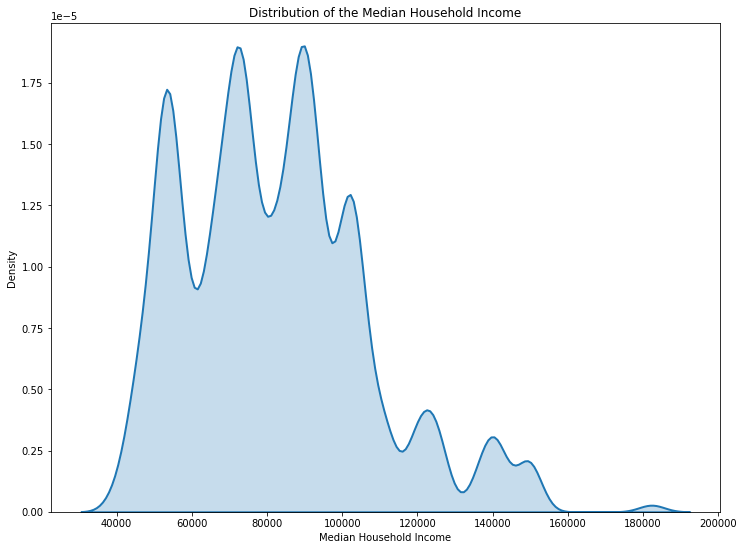

In [83]:
#presentation style
plt.figure(figsize=(12, 9))
ax = sns.kdeplot(x=data_merged['median_household_income'], shade=True, linewidth=2)
ax.set_title("Distribution of the Median Household Income")
ax.set_xlabel("Median Household Income")

In [84]:
# create an adjusted median_household income feature. Assign arbitary values

def lowIncome(income):
    if income >=  80000:
        return income
    elif (income < 80000) & (income >= 65000):
       return income * 0.90
    else:
        return income * 0.70

data_merged['adjusted_median_household_income'] = data_merged['median_household_income'].apply(lowIncome)

In [85]:
print("Adjusted minimum median household income: $%0.2f" % data_merged['adjusted_median_household_income'].min())
print("Minimum median household income: $%0.2f" % data_merged['median_household_income'].min())

Adjusted minimum median household income: $28459.20
Minimum median household income: $40656.00


### Remove outliers

Outliers - bedrooms, sqft_lot, sqft_living and price as the mean is being pulled towards the extreme values

In [86]:
# remove extreme values 
data = data_merged[(data_merged['bedrooms'] < 33)  & (data_merged['sqft_lot'] < 1000000) & (data_merged['sqft_living'] < 13540) & (data_merged['price'] < 3000000)]
data.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,population,median_household_income,adjusted_median_household_income
count,19950.000000000,19950.000000000,19950.000000000,19950.000000000,19950.000000000,19950.000000000,19950.000000000,19950.000000000,19950.000000000,19950.000000000,...,19950.000000000,19950.000000000,19950.000000000,19950.000000000,19950.000000000,19950.000000000,19950.000000000,19950.000000000,19950.000000000,19950.000000000
mean,4580361019.432129860,3.365864662,2.110075188,2069.959498747,14821.220050125,1.495538847,0.006616541,0.229674185,3.409573935,7.649122807,...,82.337894737,98077.963007519,47.559817303,-122.213933133,1982.499097744,12721.328170426,531854.669624060,31919.053984962,82250.618045113,76677.258761899
std,2874781167.145298481,0.905382777,0.759079580,891.292462726,37439.811039624,0.540555509,0.081074609,0.756002030,0.651691306,1.161737729,...,396.960842066,53.434857623,0.138626892,0.140716083,680.368516567,27062.011957872,326572.517687387,11500.212840419,24438.128409077,29970.940753715
min,1000102.000000000,0.000000000,0.000000000,290.000000000,520.000000000,1.000000000,0.000000000,0.000000000,1.000000000,1.000000000,...,0.000000000,98001.000000000,47.155900000,-122.519000000,399.000000000,651.000000000,75000.000000000,3080.000000000,40656.000000000,28459.200000000
25%,2123049439.500000000,3.000000000,1.750000000,1425.500000000,5033.250000000,1.000000000,0.000000000,0.000000000,3.000000000,7.000000000,...,0.000000000,98033.000000000,47.470200000,-122.329000000,1481.000000000,5100.000000000,321000.000000000,22772.000000000,65321.000000000,58788.900000000
50%,3904980150.000000000,3.000000000,2.250000000,1910.000000000,7609.500000000,1.500000000,0.000000000,0.000000000,3.000000000,7.000000000,...,0.000000000,98065.000000000,47.571150000,-122.230500000,1840.000000000,7620.000000000,450000.000000000,31778.000000000,81037.000000000,81037.000000000
75%,7309050175.000000000,4.000000000,2.500000000,2540.000000000,10651.500000000,2.000000000,0.000000000,0.000000000,4.000000000,8.000000000,...,0.000000000,98117.000000000,47.678100000,-122.124000000,2360.000000000,10073.250000000,640000.000000000,40610.000000000,93573.000000000,93573.000000000
max,9900000190.000000000,11.000000000,7.500000000,8670.000000000,982998.000000000,3.500000000,1.000000000,4.000000000,5.000000000,13.000000000,...,2015.000000000,98199.000000000,47.777600000,-121.315000000,6210.000000000,871200.000000000,2998000.000000000,60920.000000000,182308.000000000,182308.000000000


### Correlation

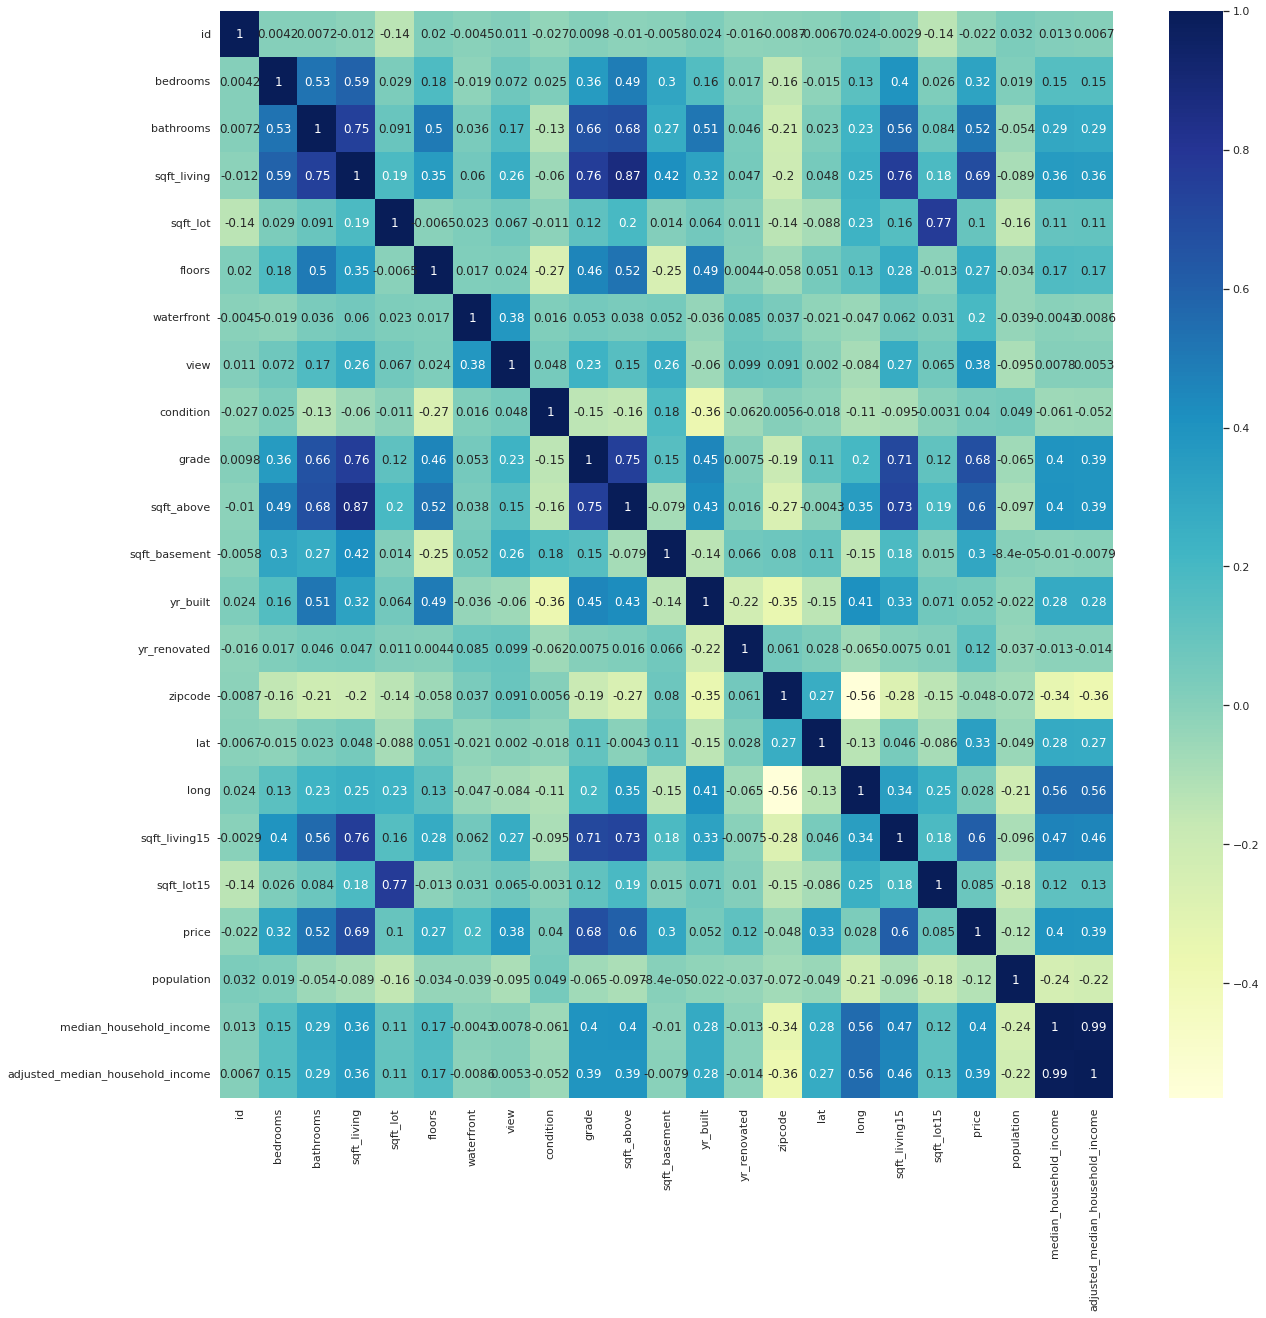

In [87]:
data.corr()

sns.set(rc = {'figure.figsize':(20,20)})

# plotting correlation heatmap
dataplot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

Price has the highest positive correlation with grade followed by sqft_living. But grading and sqft_living are both highly correlated with each other. 

In [88]:
# filter only sqft_living and price
df = data.loc[:, ['sqft_living', 'price']]
df.head()
min_sqft_living = df['sqft_living'].min()
print("Min sqft living: %d sq feet"  % (min_sqft_living))
max_sqft_living = df['sqft_living'].max()
print("Max sqft living: %d sq feet"  % (max_sqft_living))

Min sqft living: 290 sq feet
Max sqft living: 8670 sq feet


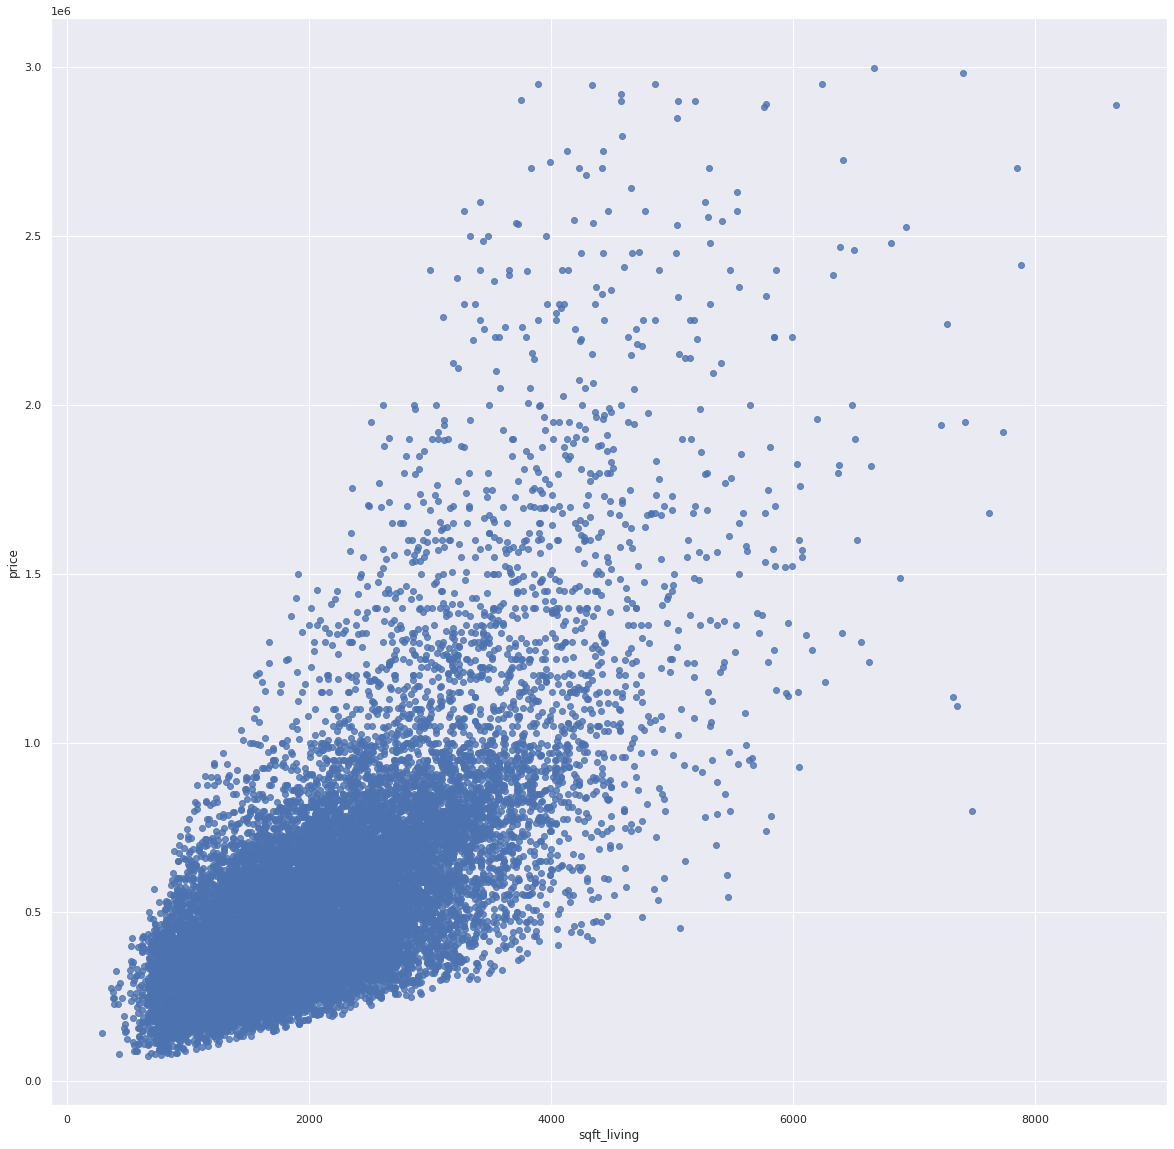

In [89]:
# visualise sqft_living-price relationship
sns.regplot(x="sqft_living", y="price", data=df, fit_reg=False)

In [ ]:
# train-test 70-30 split
df_train, df_test = train_test_split(data, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state = 85)

# rescale the features
scaler = MinMaxScaler()

# apply scaler() to all the numeric columns 
numeric_vars = ['bedrooms', 'bathrooms','sqft_living', 'sqft_lot', 'floors', 'waterfront', 'grade', 'sqft_above', 'sqft_basement',  'yr_renovated',  'adjusted_median_household_income']
df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])
df_train.head()

In [ ]:
# apply rescaling to the test set also
df_test[numeric_vars] = scaler.fit_transform(df_test[numeric_vars])
#df_test.head()

In [ ]:
# apply log transformation to the train price
df_train['logprice'] = np.log(df_train['price'])
#print(df_train.head())

apply log transformation for y_train and y_test

In [ ]:
# apply log transformation on test data price
df_test['logprice'] = np.log(df_test['price'])
#print(df_test.head())

Text(0.5, 0, 'Price of Houses')

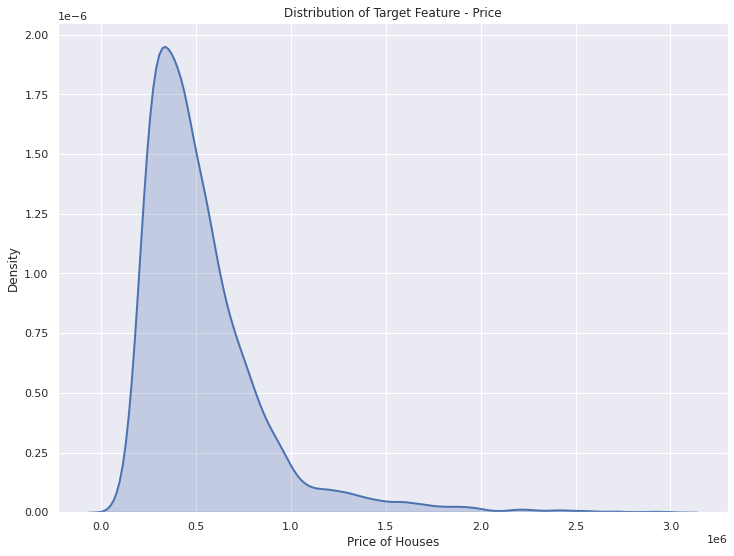

In [ ]:
#presentation style
plt.figure(figsize=(12, 9))
ax = sns.kdeplot(x=df_train['price'], shade=True, linewidth=2)
ax.set_title("Distribution of Target Feature - Price")
ax.set_xlabel("Price of Houses")

Text(0.5, 0, 'Log Price of Houses')

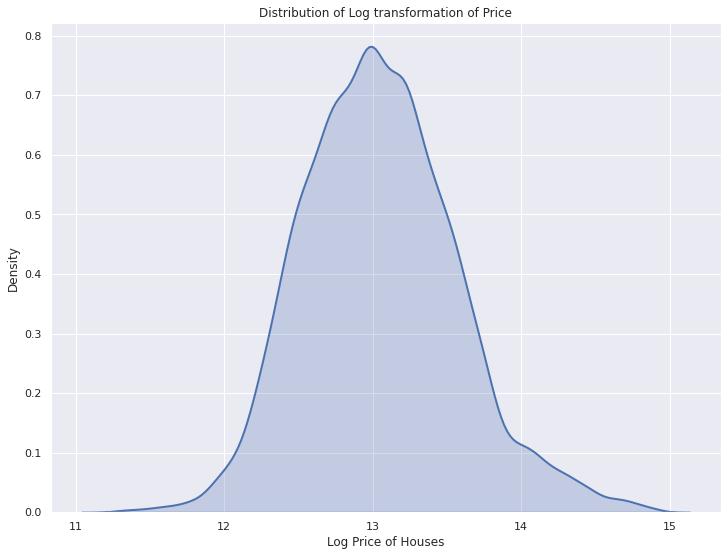

In [ ]:
#presentation style
plt.figure(figsize=(12, 9))
ax = sns.kdeplot(x=df_train['logprice'], shade=True, linewidth=2)
ax.set_title("Distribution of Log transformation of Price")
ax.set_xlabel("Log Price of Houses")

In [72]:
# keep only model features
model_features = ['bedrooms', 'bathrooms','sqft_living', 'sqft_lot', 'floors', 'waterfront',  'grade', 'sqft_above', 'sqft_basement', 'yr_renovated', 'median_household_income']

#  divide into X_train, y_train, X_test, y_test
y_train = df_train['price']
ytrain = df_train.pop('logprice')
X_train = df_train[model_features]

y_test = df_test['price']
ytest = df_test.pop('logprice')
X_test = df_test[model_features]

NameError: ignored

In [71]:
print("The length of the training set is: ", len(X_train), 
      "\nThe length of the testing data set is: ", len(X_test))

NameError: ignored

In [ ]:
print(len(y_train))
print(len(ytrain))
print(len(X_train))

15960
15960
15960


In [ ]:
print(len(y_test))
print(len(ytest))
print(len(X_test))

3990
3990
3990


In [ ]:
# first model with an arbitrary choice of n_features
# use log transformation

gbr = GradientBoostingRegressor(random_state=0, learning_rate=0.2)
baseline = gbr.fit(X_train, ytrain)
baseline.get_params(deep=True)

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.2,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# num of max features to be used in the model is a hyperparameter.
len(X_train.columns)

11

In [ ]:
# Get predictions for our test data
predictions = gbr.predict(X_test)
predictions

array([13.64251408, 13.19582801, 13.29543889, ..., 13.17385983,
       13.09981728, 12.54928961])

In [ ]:
# Compute the Root Mean Squared Error of the predictions

log_mse = mean_squared_error(ytest, predictions, squared=False)
print("Log price MSE: %0.3f" %(log_mse))

# Off by log 173 263 on average
# 0.264 with log transformation of price

Log price MSE: 0.264


In [ ]:
# convert MSE log price to $ price
dollar_mse = np.exp(log_mse)
print("Dollar price mean square error: $%0.3f" %(dollar_mse))
# $1.303

Dollar price mean square error: $1.303


## Cross-Validation

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,population,median_household_income,adjusted_median_household_income
10593,8946400100,2014-08-04,0.272727273,0.333333333,0.208000000,0.005179016,0.400000000,0.000000000,0,3,...,0.000000000,98072,47.751100000,-122.170000000,2110,4581,488000.000000000,22485,107009,0.510564918
13655,5101405465,2015-02-03,0.272727273,0.266666667,0.161333333,0.004516371,0.400000000,0.000000000,0,4,...,0.000000000,98125,47.701200000,-122.322000000,1730,6380,463000.000000000,37560,52353,0.053220435
17633,818500100,2014-06-03,0.181818182,0.333333333,0.114666667,0.002154870,0.400000000,0.000000000,0,3,...,0.000000000,98003,47.323600000,-122.323000000,1430,3609,174500.000000000,45632,45563,0.022326466
11897,8644400040,2014-07-29,0.363636364,0.300000000,0.284000000,0.031566754,0.400000000,0.000000000,0,4,...,0.000000000,98074,47.615300000,-122.054000000,2510,39221,605000.000000000,26386,140799,0.730196141
16725,3629980860,2014-07-07,0.363636364,0.366666667,0.260000000,0.003407890,0.400000000,0.000000000,0,3,...,0.000000000,98029,47.552500000,-121.990000000,2410,4063,680000.000000000,26193,99519,0.461880756


## XGBoost Regressor

In [ ]:
# X = X_train
# y = y_train

In [ ]:
# create an xgboost regression model
xgb1 = XGBRegressor()
# create an xgboost regression model
xgb2 = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [ ]:
# define model evaluation method
cv = RepeatedKFold(n_splits=20, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(xgb1, X_train, ytrain, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [ ]:
# force scores to be positive
from numpy import absolute
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
# Mean MAE: 101214.060 (4498.337)

Mean MAE: 0.182 (0.006)


## Save model

In [ ]:
# save the model to disk
filename = 'finalized_price_model.sav'
pickle.dump(xgb1, open(filename, 'wb'))

## Prepare Holdout Sample

### Add median_household_income

In [ ]:
holdout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1613 entries, 0 to 1612
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1613 non-null   int64  
 1   date           1613 non-null   object 
 2   bedrooms       1613 non-null   int64  
 3   bathrooms      1613 non-null   float64
 4   sqft_living    1613 non-null   int64  
 5   sqft_lot       1613 non-null   int64  
 6   floors         1613 non-null   float64
 7   waterfront     1613 non-null   int64  
 8   view           1613 non-null   int64  
 9   condition      1613 non-null   int64  
 10  grade          1613 non-null   int64  
 11  sqft_above     1613 non-null   int64  
 12  sqft_basement  1613 non-null   int64  
 13  yr_built       1613 non-null   int64  
 14  yr_renovated   1613 non-null   int64  
 15  zipcode        1613 non-null   int64  
 16  lat            1613 non-null   float64
 17  long           1613 non-null   float64
 18  sqft_liv

In [ ]:
# inflation between 2014 and 2015 hardly changed.
zipcode = pd.read_csv('https://raw.githubusercontent.com/Kate-Strydom/cse450/main/notebooks/zipcode_washington.csv')

# merge data on zipcodes
holdout_merged = holdout.merge(zipcode, left_on='zipcode', right_on='zipcode')

In [ ]:
# create an adjusted median_household income feature. Assign arbitary values

def lowIncome(income):
    if income >=  80000:
        return income
    elif (income < 80000) & (income >= 65000):
       return income * 0.90
    else:
        return income * 0.70

holdout_merged['adjusted_median_household_income'] = holdout_merged['median_household_income'].apply(lowIncome)

In [ ]:
# rescale the features
scaler = MinMaxScaler()

# apply scaler() to all the numeric columns 
numeric_vars = ['bedrooms', 'bathrooms','sqft_living', 'sqft_lot', 'floors', 'waterfront', 'grade', 'sqft_above', 'sqft_basement',  'yr_renovated',  'adjusted_median_household_income']
df_holdout = holdout_merged[numeric_vars]
df_holdout[numeric_vars] = scaler.fit_transform(df_holdout[numeric_vars])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
df_holdout.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,sqft_basement,yr_renovated,adjusted_median_household_income
0,0.500000000,0.375000000,0.234848485,0.005023750,0.400000000,0.000000000,0.444444444,0.283675290,0.000000000,0.000000000,0.342945801
1,0.500000000,0.291666667,0.231818182,0.056898069,0.000000000,0.000000000,0.333333333,0.137377342,0.343347639,0.000000000,0.342945801
2,0.375000000,0.291666667,0.231818182,0.005115829,0.400000000,0.000000000,0.222222222,0.280107047,0.000000000,0.000000000,0.342945801
3,0.250000000,0.166666667,0.059090909,0.005614993,0.000000000,0.000000000,0.222222222,0.076717217,0.000000000,0.000000000,0.342945801
4,0.625000000,0.500000000,0.260606061,0.011200908,0.000000000,0.000000000,0.444444444,0.217662801,0.231759657,0.000000000,0.342945801


In [1]:
# load the model from disk
loaded_gbr_model = pickle.load(open(filename, 'rb'))
#result = loaded_gbr_model.score(df_holdout, y_test)
#print(result)


NameError: ignored

In [ ]:
np.sq

In [ ]:
# make a prediction
yhat = loaded_gbr_model.predict(df_holdout)
# summarize prediction
print('Predicted: %.3f' % yhat)

XGBoostError: ignored

## Score New Data